# MNIST Tutorial
In this tutorial, we will first use `tensorflow` and `keras` to build a simple fully connected neural network to perform hand written digit classification on MNIST dataset. Then we will dive into the details of how to write a neural network from scratch. Basically, we will re-implement the functionality of `keras` from scratch, without the help of tensorflow or any machine learning frameworks.

## Keras
Step one, let's build a simple sequential model using `keras` and we will see how powerful `keras` is. It should only take us less than 10 lines of code to build a 3-layer fully connected network.

In [1]:
import warnings
warnings.filterwarnings('ignore')

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.regularizers import l2

from matplotlib import pyplot as plt

import numpy as np


# Build the neural network!
model = Sequential()
model.add(Dense(300, input_dim=28*28, kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dense(50, input_dim=300, kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dense(10, input_dim=100))
model.add(Activation('softmax'))

Using TensorFlow backend.


Now we will grab MNIST hand-written digit data through `keras`.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Let's visualize them and see how do the data look like.

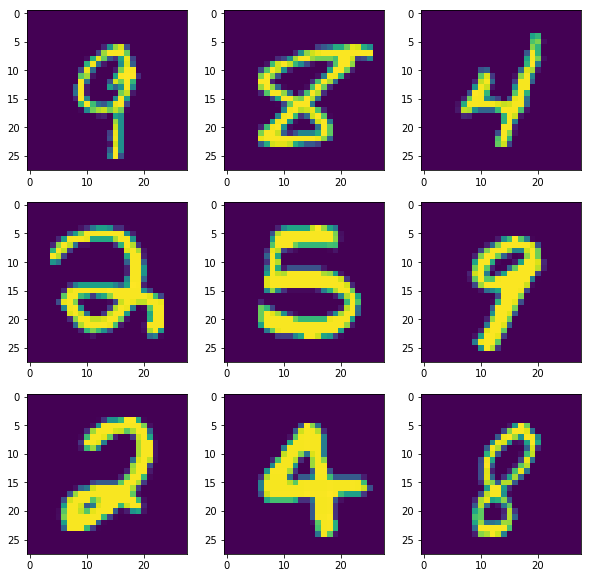

In [3]:
from utils import visualize_img_data

visualize_img_data(x_train)

Now here comes the magic of `keras`. We can train the network using as few as 3 lines of code!

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 3s 63us/step - loss: 1.9959 - acc: 0.8826 - val_loss: 0.6230 - val_acc: 0.9272
Epoch 2/10
48000/48000 [==============================] - 3s 62us/step - loss: 0.5144 - acc: 0.9275 - val_loss: 0.4369 - val_acc: 0.9403
Epoch 3/10
48000/48000 [==============================] - 3s 61us/step - loss: 0.4345 - acc: 0.9378 - val_loss: 0.3999 - val_acc: 0.9466
Epoch 4/10
48000/48000 [==============================] - 3s 62us/step - loss: 0.4030 - acc: 0.9434 - val_loss: 0.3807 - val_acc: 0.9517
Epoch 5/10
48000/48000 [==============================] - 3s 60us/step - loss: 0.3846 - acc: 0.9460 - val_loss: 0.3658 - val_acc: 0.9517
Epoch 6/10
48000/48000 [==============================] - 3s 62us/step - loss: 0.3698 - acc: 0.9496 - val_loss: 0.3505 - val_acc: 0.9572
Epoch 7/10
48000/48000 [==============================] - 3s 62us/step - loss: 0.3587 - acc: 0.9519 - val_loss: 0.3455 - val_acc

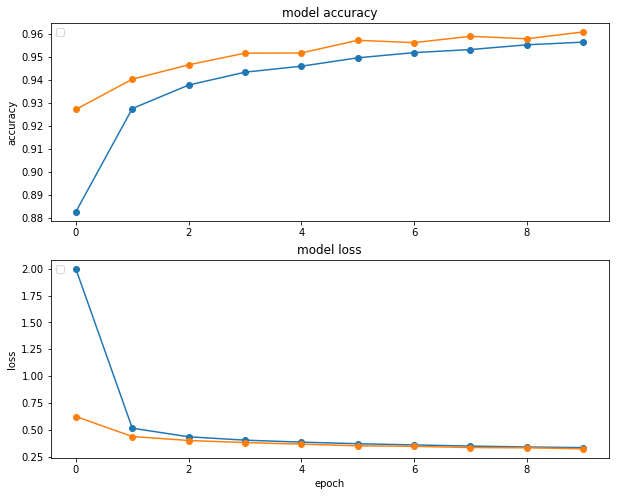

In [4]:
from utils import plot_histo_chart


# Massage the data first
N, H, W = x_train.shape
x = x_train.reshape((N,H*W)).astype('float') / 255
y = to_categorical(y_train, num_classes=10)

# Define optimizer
sgd = SGD(lr=0.01, decay=1e-4, momentum=0.9)

# Compile the model
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Train it
plot_histo_chart(model.fit(x, y, validation_split=0.20, epochs=10, batch_size=50))

Now training is done, we are ready to evaluate the model.

In [5]:
N, H, W = x_test.shape
x = x_test.reshape(N, H*W).astype('float') / 255
y = to_categorical(y_test, num_classes=10)

test_loss, test_acc = model.evaluate(x, y, batch_size=50)
print 'Accuracy on test data %f' % test_acc

10000/10000 [==============================] - 0s 23us/step
Accuracy on test data 0.958100


That is a 95.8% accuracy on test data! This isn't bad but it isn't the best. We can achieve 99.8% if we use convolutional neural network. This is a topic for another tutorial.

## Implement From Scratch
Now it is time to implement everything from scratch. The source code can be found on [GitHub][1]. We are going to deep dive into every detail of the implementation to get a full understanding of what's going on. It is important to understsand how to perform gradient calculation using the idea of a [computational graph][2] before we proceed onto writing code. In every layer, we will focus on calculating the local gradients and use chain rule to compute the gradient with respect to loss.

[1]:https://github.com/calvinfeng/machine-learning-notebook/tree/master/mnist_tutorial
[2]:http://colah.github.io/posts/2015-08-Backprop/

## Dense
The first layer we will implement is the `Dense` layer. We need logic for both forward propagation and backpropagation in this layer. 

### Forward Propagation
Let's begin with forward propagation:

$$
y = \vec{x}W + b
$$

$W$ is our weight matrix and $b$ is the bias vector. We take an input, which is $\vec{x}$, and perform an [affine][3] transformation on it. The input to our forward propagation function can be any shape, e.g. `(N, 28, 28, 3)`, this represents N 28x28 images with 3 channels (RGB). However, the weight matrix must be of shape `(28*28*3, H)` where H is the hidden unit dimension. Thus, the input needs to be reshaped before we carry out the matrix multiplication.
```python
    def forward_prop(self, x, w, b):
        self.input = x
        self.weight = w
        self.bias = b

        D = np.prod(x.shape[1:])
        x_reshaped = x.reshape(x.shape[0], D)

        return np.dot(x_reshaped, w) + b
```

[3]:https://en.wikipedia.org/wiki/Affine_transformation

### Backpropagation
It should be the layer's responsibility to compute local gradients and apply chain rule to them to obtain gradient of loss. What are local gradients? They are the gradient of $y$ with respect to $x$, $W$, and $b$, as opposed to the gradient of loss (which is global gradient in our context.)

$$
\frac{\partial y}{\partial W} = x^{T}
$$

$$
\frac{\partial y}{\partial x} = W^{T}
$$

$$
\frac{\partial y}{\partial b} = 1
$$

#### Tensor Calculus
Notice that we are doing tensor calculus, the actual derivation of differentiation isn't very clean. It involves constructing a Jacobian matrix because we are basically taking derivative of a vector i.e. $y$ with respect to a matrix, i.e. $W$. For more information, please look at [Prof. Erik Learned-Miller's note][4]. 

For now, let's look at a simple example to prove the equations above:

$$
\vec{x} = [x_{1}, x_{2}, x_{3}] \\
\vec{b} = [b_{1}, b_{2}]
$$

And

$$
W = \begin{bmatrix}
w_{1,1} & w_{1,2} \\ 
w_{2,1} & w_{2,2} \\
w_{3,1} & w_{3,2}
\end{bmatrix}
$$

Thus, $y$ is

$$
y = \begin{bmatrix}
w_{1,1}x_{1} + w_{2,1}x_{2} + w_{3,1}x_{3} & w_{1,2}x_{1} + w_{2,2}x_{2} + w_{3,2}x_{3}
\end{bmatrix}
$$

Now if we want to take derivative of $y$ with respect to $\vec{x}$, we need to construct a Jacobian.

$$
\frac{\partial y}{\partial \vec{x}} = \begin{bmatrix}
\frac{\partial y_{1}}{\partial x_{1}} & \frac{\partial y_{1}}{\partial x_{2}} & \frac{\partial y_{1}}{\partial x_{3}} \\
\frac{\partial y_{2}}{\partial x_{1}} & \frac{\partial y_{2}}{\partial x_{2}} & \frac{\partial y_{2}}{\partial x_{3}}
\end{bmatrix}
$$

That is equivalent to the transpose of weight matrix!

$$
\frac{\partial y}{\partial \vec{x}} = \begin{bmatrix}
w_{1,1} & w_{2,1} & w_{3,1} \\
w_{1,2} & w_{2,2} & w_{3,2} 
\end{bmatrix} = W^{T}
$$

#### Dimension Analysis
Anyways, my typical lazy approach to the problem is dimension analysis. We know that upstream gradient, the gradient of loss with respect to $y$ has the shape `(N, H)`. We know that $x$ has the shape `(N, D)`. We are expecting to get the gradient of $y$ with respect to $W$, which should have the shape of `(D, H)`. This is translating to the following in code:
```python
# Applying vector chain rule, as a result, grad_w is the gradient of loss with respect to weight
grad_w = np.dot(x.T, grad_y)  # (D, N) x (N, H) => (D, H)
```

Similarly, we can do the same for gradient of $x$:
```python
# Applying vector chain rule, as a result, grad_x is the gradient of loss with respect to input
grad_x = np.dot(grad_y, w.T)
```

Since the local gradient of bias is 1, the gradient of loss with respect to $y$ is going to be the gradient we use for updating biases. But the problem is that `grad_y` has shape `(N, H)` while bias vector has shape `(H,)`. this just means that we need to sum up the contributions from N examples.
```
grad_b = np.sum(grad_y.T, axis=1)
```

Now put everything together.
```python
    # grad_output is grad_y, I use the two terms interchangeably
    def backprop(self, grad_output):
        if self.input is not None and self.weight is not None:
            D = np.prod(self.input.shape[1:])
            input_reshaped = self.input.reshape(self.input.shape[0], D)

            grad_w = np.dot(input_reshaped.T, grad_output)
            grad_x = np.dot(grad_output, self.weight.T).reshape(self.input.shape)
            grad_b = np.sum(grad_output.T, axis=1)

            return grad_x, grad_w, grad_b  
```

[4]:https://compsci697l.github.io/docs/vecDerivs.pdf

## ReLU Activation
ReLU stands for rectified linear unit. It squashes all negative inputs to zero and keeps the value of all positive inputs. 
```python
relu(1)  # => 1
relu(52342)  # => 52342
relu(-1)  # => 0
relu(-4232)  # => 0
```

### Forward Propagation
$$
f(x) = \begin{cases}
\text{if } x > 0 \quad \text{ return } x \\  
\text{if } x <= 0 \quad \text{ return } 0 
\end{cases}
$$

The implementation is extremely simple.
```python
def forward_prop(self, x):
    return np.maximum(0, x)
```

### Back Propagation
ReLU acts as a switch. If any input is negative, it won't pass the input forward to next layer. If any input is positive, it will pass the input forward to next layer without any additional modifications. What does that imply? Whenever the input is positive, we have a slope of 1 because the change is linearly proportional to the input. This is like: 

$$
\text{ Given } f(x) = x \rightarrow \frac{\partial f}{\partial x} = 1
$$

Whenever the input is negative, we have a slope of zero because there isn't any change! This is like:

$$
\text{ Given } f(x) = 0 \rightarrow \frac{\partial f}{\partial x} = 0
$$

We can expect that our local gradient is filled with ones and zeros in a matrix of shape `(N, H)`. We will multiply the local gradient by the upstream gradient. With that mind, we can take a short cut and write:
```python
def backprop(self, grad_output):
    grad_input = grad_output
    grad_input[self.input <= 0] = 0  # Set all entries, where inputs were negative, to zero.
```
